# A Quantitative Analyst's Workflow for AAPL

---

## Section 1 : Why??

Sebelum kita analisis dan buat model, kita perlu ngerti dulu, kenapa kita mau prediksi harga saham AAPL??

### 1.1. Tujuan - Capital Gain & Risk Management

balik ke dasar dalam finance dan investment, invest ke capital market itu tujuannya yang gedein uang kita. nah model disini dipake untuk bantu analisis informasi atau data yang ada dengan lebih efisien dan otomatis. of course model gaakan sempurna, karena pada dasarnya sulit untuk mebemukan pola dalam human behavior penggerak ekonomi. tapi setidaknya ini bisa dijadikan bantuan dalam management investment portofolio kita.

### 1.2. Apa yang Mau di Prediksi??

Kita mau bikin model yang bisa prediksi close value dari AAPL keesokan harinya.  secara simpel itu kaya gini

$Prediksi Harga Besok = fungsi(Data Haei Ini)$

atau :

$Predicted\_Close(t+1) = f(X_t)$



Btw, kita cuma pake data sampe hari ini buat nebak harga besok. Gak boleh tau data besok buat bisa prediksi hari ini, ini disebut lookahead bias, dan ini haram hukumnya di finance modelling.

so, fitur yang kita pake untuk prediksi adalah

- harga pembukaan, tertinggi, terendah, close, dan volume (OHCLC).
- semua data diambil dari data hari hari sebelumnya, sampai hari ini.

### 1.3. Datanya dari mana?? `yfinance` jawabannya

Kita akan menggunakan data harian `OHLCV` (Open, High, Low, Close, Volume) untuk saham 'AAPL', menggunakan `yfinance`. kita bakal ambil data selama 5 tahun terakhir, kenapa 5 tahun?. well, 5 tahun adalah waktu yang udah cukup untuk dapet pola perubahan pasar, naik turun, big event kaya covid dan kenaikan suku bunga. dan juga ga terlalu lama yang bikin data ga relevan ikut masuk dan bikin model bias atau pusing nangkep pola.

#### Dependencies 


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import shap
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Set style background ungu gelap
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (15, 7)

print("Semua library berhasil di-import.")

Semua library berhasil di-import.


#### Data

In [18]:
# ticker dan periode waktu
ticker = 'AAPL'
start_date = '2019-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

try:
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError("Datanya kosong. Mungkin ticker-nya salah atau gak ada data.")
    print(f"Data {ticker} berhasil diambil dari {start_date} sampai {end_date}.")
    print("\nInformasi umum data:")
    data.info()
except Exception as e:
    print(f"Error ambil data: {e}")

# Drop 'AAPL'
data.columns = data.columns.droplevel(1)  

# Lihat isi data
print("\nLima baris pertama:")
display(data.head())

print("\nStatistik umum:")
display(data.describe())

/var/folders/fz/vv4pwkl920qbrm78wf1yyykr0000gn/T/ipykernel_21427/3107071363.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data AAPL berhasil diambil dari 2019-01-01 sampai 2025-07-31.

Informasi umum data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1653 entries, 2019-01-02 to 2025-07-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1653 non-null   float64
 1   (High, AAPL)    1653 non-null   float64
 2   (Low, AAPL)     1653 non-null   float64
 3   (Open, AAPL)    1653 non-null   float64
 4   (Volume, AAPL)  1653 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 77.5 KB

Lima baris pertama:


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,37.617859,37.839395,36.738870,36.896088,148158800
2019-01-03,33.870838,34.711713,33.825578,34.297229,365248800
2019-01-04,35.316761,35.385843,34.254354,34.428245,234428400
2019-01-07,35.238148,35.452537,34.754585,35.421569,219111200
2019-01-08,35.909904,36.164789,35.378701,35.626436,164101200



Statistik umum:


Price,Close,High,Low,Open,Volume
count,1653.000000,1653.000000,1653.000000,1653.000000,1.653000e+03
mean,141.943203,143.392510,140.335096,141.795834,9.090863e+07
std,56.667378,57.149589,56.122785,56.621454,5.157802e+07
min,33.870838,34.711713,33.825578,34.297229,2.323470e+07
25%,108.883003,110.309660,106.730760,109.038826,5.527590e+07
50%,146.816757,148.404486,145.317234,146.473738,7.775800e+07
75%,181.424316,183.314295,179.913701,181.255329,1.090120e+08
max,258.396667,259.474086,257.010028,257.568678,4.265100e+08


**Analisis :**

Junmlah data  (count) 1653 sekitar 6.5 tahun. 

Mean Close 141. open high low, juga ada dikisaran yang sama, stabil.

volume rata rata sekita 9.0 juta saham per hari, sangat likuid

Distribusi - std close - 56.7 volitilitas harian cukup tinggi, std volume - 5.1 jt, fluktuasi besar juga. ada hari tertentu yang nilainya ekstrim. Intinya range of distribution yang tinggi mewajibkan scaling atau norm sebelum modelling.

harga close terendah  33, harga close tertinggi 258. selisih besar. volume min 23jt, volume max 400 jt. selisih besar juga. masuk akal, tapi sebelum modelling kita perlu log transform ini, biar rentang nya lebih stabil. 

Quartile - median cloose 146, lebih tinggi dari meannya, menandakan varians rendah, atau left skewed, atau distribusi tidak normal.

IQR (InterQuartile Range) ; Q3 - Q1 = 180 - 110 -> 70. perubahan yang cukup besar dan signifikan.

Kesimpulan : Data cukup banyak dan berkualitas serta valid, saham likuid, violitas tinggi, bagus untuk model prediksi, namun perlu dihandle outlier dengan normalisasi.





	Daily Range: High - Low → indikator volatilitas harian
	•	Price Change: Close - Open → arah pergerakan harian
	•	Body Ratio: (Close - Open) / (High - Low) → bentuk candlestick
	•	Normalized Volume: (Volume - mean) / std → volume outlier detection
	•	Lag Features: Harga & volume kemarin, 3 hari lalu, 7 hari lalu, dst.

---

## Section 2 : EDA

EDA atau exploratori data analysis adalah menganalisa data, artinya kita peke metode statistik dan analisis lainnya untuk memahami data, seperti bagaimana data terdistribusi, tren paarnya itu gimana, analisis statistik untuk dapetin informasi statistik Inferensi (tiem series, sequential).

### 2.1. Handling Null Values

In [9]:
data.isnull().sum()

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

lucky me gaada missing value, lets just move on

### 2.2. Grafik Harga Historis dan Valume

kita bakal bikin grafik harga penutupan (Close) dan volume perdagangan pada hari itu, dan kemudian melihat pola yang ada. 

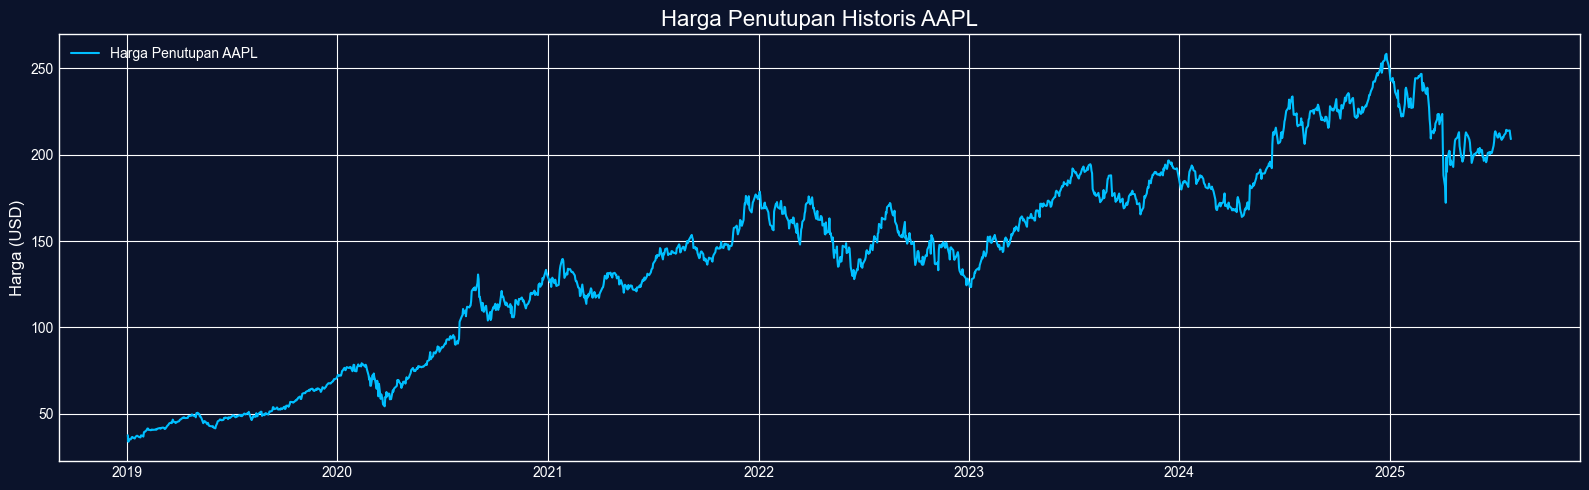

In [26]:
fig, ax1 = plt.subplots(figsize=(16, 5)); fig.patch.set_facecolor('#0b132b'); ax1.set_facecolor('#0b132b')

ax1.plot(data['Close'], label='Harga Penutupan AAPL', color='#00bfff')
ax1.set_title(f'Harga Penutupan Historis {ticker}', fontsize=16, color='white')
ax1.set_ylabel('Harga (USD)', fontsize=12, color='white')
ax1.legend(facecolor='#0b132b', edgecolor='white')

ax1.tick_params(colors='white')
for spine in ax1.spines.values(): spine.set_color('white')
plt.tight_layout(); plt.show()

**Analisis :**

membangun model prediksi harga saham, maka analisis kita harus fokus ke keterkaitan antara harga penutupan dan volume perdagangan, serta bagaimana pola historis keduanya bisa memberikan sinyal prediktif. Jadi kita gak cuma ngelihat tren, tapi mulai berpikir: apakah volume bisa bantu memprediksi pergerakan harga berikutnya?

Dari grafik harga penutupan, terlihat bahwa AAPL mengalami tren naik yang cukup stabil. Artinya, ada pola historis yang bisa ditangkap oleh model time-series atau machine learning. Harga penutupan menunjukkan autocorrelation—pergerakan hari ini sebagian besar dipengaruhi oleh hari-hari sebelumnya. Ini bagus, karena model seperti ARIMA, LSTM, atau bahkan XGBoost dengan fitur waktu bisa memanfaatkan pola ini.

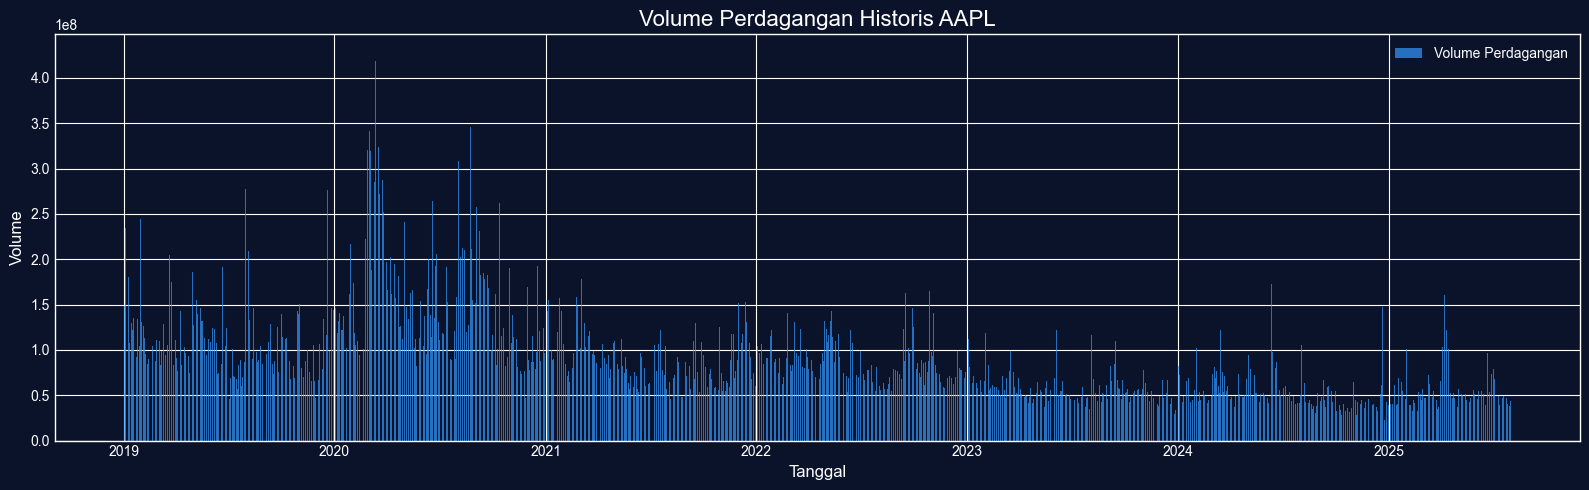

In [32]:
fig, ax2 = plt.subplots(figsize=(16, 5)); fig.patch.set_facecolor('#0b132b'); ax2.set_facecolor('#0b132b')

ax2.bar(data.index, data['Volume'], label='Volume Perdagangan', color='#3399ff', alpha=0.7)
ax2.set_title(f'Volume Perdagangan Historis {ticker}', fontsize=16, color='white')
ax2.set_ylabel('Volume', fontsize=12, color='white')
ax2.set_xlabel('Tanggal', fontsize=12, color='white')
ax2.legend(facecolor='black', edgecolor='white')

ax2.tick_params(colors='white')
for spine in ax2.spines.values(): spine.set_color('white')
plt.tight_layout(); plt.show()

**Analisis :**

Sekarang, lihat grafik volume. Volume tidak memiliki tren yang stabil, tapi justru sangat fluktuatif dan kadang melonjak drastis. Namun, lonjakan volume ini sering kali mendahului pergerakan harga besar. Ini berarti volume bisa dijadikan sebagai leading indicator. Misalnya, lonjakan volume tanpa kenaikan harga bisa menandakan akumulasi sebelum breakout. Ini sinyal yang sangat berguna buat model prediksi.

Insight untuk modelling:
- Harga penutupan memiliki pola tren dan seasonality → cocok untuk time-series modelling.
- Volume memiliki karakteristik volatil dan bisa menjadi sinyal awal sebelum pergerakan harga → berguna sebagai fitur prediktor.
- Kombinasi keduanya penting. Harga penutupan sebagai target variabel, volume sebagai salah satu fitur prediktif (bisa ditambah turunan lain seperti perubahan volume, rata-rata bergerak, RSI, dll).
- Untuk hasil lebih baik, model bisa juga diberi fitur turunan waktu seperti hari, minggu, dan kuartal karena saham punya pola musiman.

Intinya, secara data: harga penutupan memberi fondasi tren, sementara volume memberi sinyal momentum. Gabungan ini yang akan memperkuat model prediksi harga ke depan.